In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
learning_rate = 0.001
input_size = 32
num_epoch = 10
 
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
my_model = torchvision.models.resnet18(pretrained=True)
#my_model = torchvision.models.vgg16(pretrained=True)
my_model.fc = nn.Linear(512, 100) # 100: number of output classes
my_model = my_model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(my_model.parameters(), lr=learning_rate, momentum=0.9)

In [36]:
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        print('epochs:　%d, steps: %d loss: %.3f' % (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

串流輸出內容已截斷至最後 5000 行。
epochs:　4, steps: 476 loss: 1.046
epochs:　4, steps: 477 loss: 1.272
epochs:　4, steps: 478 loss: 0.994
epochs:　4, steps: 479 loss: 1.176
epochs:　4, steps: 480 loss: 1.316
epochs:　4, steps: 481 loss: 1.018
epochs:　4, steps: 482 loss: 1.250
epochs:　4, steps: 483 loss: 1.142
epochs:　4, steps: 484 loss: 1.669
epochs:　4, steps: 485 loss: 1.194
epochs:　4, steps: 486 loss: 1.270
epochs:　4, steps: 487 loss: 1.248
epochs:　4, steps: 488 loss: 1.624
epochs:　4, steps: 489 loss: 1.095
epochs:　4, steps: 490 loss: 1.435
epochs:　4, steps: 491 loss: 1.232
epochs:　4, steps: 492 loss: 1.626
epochs:　4, steps: 493 loss: 1.173
epochs:　4, steps: 494 loss: 1.247
epochs:　4, steps: 495 loss: 0.975
epochs:　4, steps: 496 loss: 1.424
epochs:　4, steps: 497 loss: 1.266
epochs:　4, steps: 498 loss: 1.349
epochs:　4, steps: 499 loss: 1.360
epochs:　4, steps: 500 loss: 1.313
epochs:　4, steps: 501 loss: 1.475
epochs:　4, steps: 502 loss: 1.241
epochs:　4, steps: 503 loss: 1.227
epochs:　4, steps: 504 loss:

In [37]:
def preprocess_image(cv2im, resize_im=True):

    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (32, 32))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [38]:
class Pretrained_VGGNet():
    def __init__(self,img_path):
        self.img_path=img_path
        # Load pretrained model
        self.pretrained_model = my_model
        self.pretrained_model = self.pretrained_model.to(device)
        self.pretrained_model.eval()
    def process_image(self):
        img=cv2.imread(self.img_path)
        img=preprocess_image(img)
        return img

    def get_single_feature(self):
        # Get the feature map
        features=self.get_feature()
        feature=features[:,0,:,:]
        feature=feature.view(feature.shape[1],feature.shape[2])

        #print(features)
        #print(feature.shape)
        return feature

    def plot_probablity(self,outputs):

        outputs = outputs.data.cpu().numpy()
        outputs = np.ndarray.tolist(outputs)
        print(len(outputs))

        x = range(0, 100)        
        plt.bar(x, outputs[0])
        plt.xlabel("Class")
        plt.ylabel("Probablity")
        plt.title("Image classifier")
        plt.show()

    def predict(self):
        input=self.process_image()
        input = input.to(device).cuda()
        outputs = self.pretrained_model(input)

        s = torch.nn.Softmax(dim=1)
        result = s(outputs)
        self.plot_probablity(result)

        prob, predicted = result.sort(1,descending=True)
        prob = prob.data.cpu().numpy()

        predicted = predicted.data.cpu().numpy()
        
        print("Probablity TOP-3:\n")
        print("")
        for i in range(3):
            
            print("TOP_"+str(i+1))
            print("Probablity:{}".format(prob[0][i]))
            print("Predicted:{}\n".format(c[int(predicted[0][i])]))
        return outputs

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

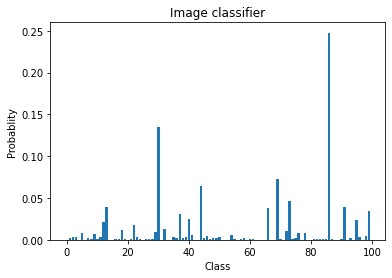

Probablity TOP-3:


TOP_1
Probablity:0.24768127501010895
Predicted: 'telephone'

TOP_2
Probablity:0.1349448710680008
Predicted: 'dolphin'

TOP_3
Probablity:0.07279378920793533
Predicted: 'rocket'



In [50]:
if __name__=='__main__':
  # get class
  c = {}
  with open("./CIFAR100_clsidx_to_labels.txt") as f:
    for line in f:
      (key, val) = line.split(":")
      c[int(key)] = val.split(",")[0]
  # Define image path
  myClass=Pretrained_VGGNet('./dolphin.jpg')
  print(myClass.pretrained_model)
  myClass.predict()